# Social Graphs Project

## Pre-processing

### Imports

In [112]:
import pandas as pd
import numpy as np
import re
import urllib.request
import json
import os
import string  
import math
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
import networkx as nx
import community
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from fa2 import ForceAtlas2
from PIL import Image, ImageFont
import requests
import json
import re

### Extract wiki data

### Data cleaning

In [222]:
df =pd.read_csv('data/final_data.csv', converters={'following': eval,'repos_name': eval},index_col=0)

df['used_languages'] = df['used_languages'].str.replace(' ',',').str.replace('\n','').str.replace("'","")
def stringToList(colname):
    df[colname] = [df[colname][i][1:len(df[colname][i])-1].split(',') for i in range(len(df))]

stringToList('used_languages')

df.head(3)

,user_name,owner,repos,name,type,company,location,bio,created_at,updated_at,...,email,followers_count,following_count,hireable,repos_count,repos_name,total_stars,total_forks,main_language,used_languages
0,josephmisiti,josephmisiti,awesome-machine-learning,Joseph Misiti,User,Math & Pencil,"Brooklyn, NY",Mathematician & Co-founder of Math & Pencil,2010-04-17T21:09:13Z,2020-10-29T18:11:39Z,...,NaN,2610,275,True,226,"[80s.nyc, alexa-skills-kit-js, algodeck, algor...",48727,12605,Python,"[C, C++, CSS, CoffeeScript, Go, HTML, Java, Ja..."
1,wepe,wepe,MachineLearning,wepon,User,AntFin,China Hangzhou,NaN,2014-10-10T14:28:18Z,2020-11-05T15:54:10Z,...,wepon@pku.edu.cn,4564,47,NaN,27,"[AliTianChi, CaiNiao-DemandForecast-StoragePla...",7324,5193,Python,"[C++, HTML, Java, Python, Shell]"
2,ZuzooVn,ZuzooVn,machine-learning-for-software-engineers,Nam Vu,User,NaN,Vietnam,A Vietnamese Software Engineer who is really p...,2012-02-11T16:55:02Z,2020-10-12T02:40:45Z,...,zuzoovn@gmail.com,1223,91,True,38,"[android-classyshark, asi-http-request, awesom...",24471,5838,Python,"[C, DIGITAL, Command, Language, HTML, Java, Ja..."


In [224]:
df['out'] = ''

for i in range(len(df)):
    df['out'][i] = np.unique([link for link in df['following'][i] if link in df['user_name'].values])

C:\Users\Julie Maria Petersen\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Generate network

In [225]:
# store the network of users with DiGraph
G = nx.DiGraph()
G.add_nodes_from(df['user_name'].values)

for row in df.iterrows():
    z = [(row[1]['user_name'], other_node) for other_node in row[1]['out']]
    G.add_edges_from(z)

# extract giant connected component 
largest_cc = max(nx.weakly_connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

## Network statistics

In [226]:
print(f"Number of nodes in G: {G.number_of_nodes()}")
print(f"Number of edges in G: {G.number_of_edges()} \n")
print(f"Number of nodes in GCC: {GCC.number_of_nodes()}")
print(f"Number of edges in GCC: {GCC.number_of_edges()}")

Number of nodes in G: 1585
Number of edges in G: 2092 

Number of nodes in GCC: 737
Number of edges in GCC: 2072


In [227]:
# find top5 in-degree nodes in network/GCC
df['in_degree'] = df['user_name'].apply(lambda x: G.in_degree(x))
print('Top 5 in-degree characters ')
display(df.sort_values(by=['in_degree'], ascending=False)[['user_name','name','in_degree']].head())

# find highest out-degree nodes in network/GCC
df['out_degree'] = df['user_name'].apply(lambda x: G.out_degree(x))
print('Top 5 out-degree characters ')
display(df.sort_values(by=['out_degree'], ascending=False)[['user_name','name','out_degree']].head())


# find highest out-degree nodes in network/GCC
df['connections'] = df['user_name'].apply(lambda x: G.degree(x))
print('Top 5 connected characters ')
display(df.sort_values(by=['connections'], ascending=False)[['user_name','connections']].head())


Top 5 in-degree characters 


,user_name,name,in_degree
367,amueller,Andreas Mueller,67
417,ogrisel,Olivier Grisel,63
574,fchollet,François Chollet,58
26,llSourcell,Siraj Raval,56
3,rasbt,Sebastian Raschka,55


Top 5 out-degree characters 


,user_name,name,out_degree
1178,yupbank,Peng Yu,68
575,feihugis,Fei Hu,43
1124,gaocegege,Ce Gao,42
1320,silverstone1903,NaN,41
1042,justinormont,Justin Ormont,36


Top 5 connected characters 


,user_name,connections
367,amueller,83
417,ogrisel,82
1178,yupbank,72
155,soumith,64
3,rasbt,60


### Node degree distribution

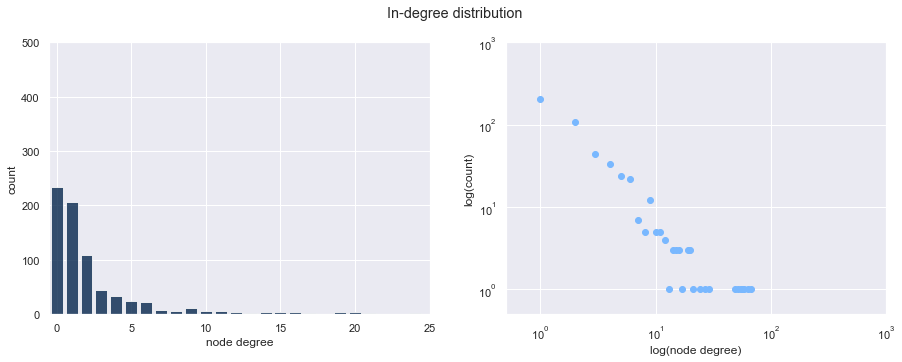

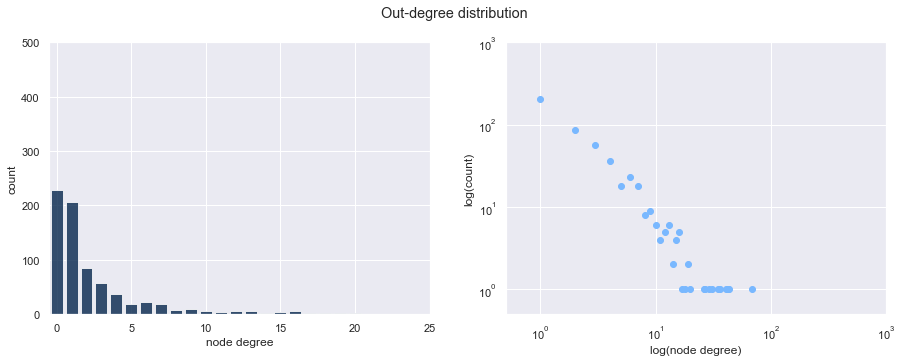

In [228]:
blue = ['#c8e1ff','#79b8ff','#0366d6','#044289','#05264c']

def degree_distribution(G, mode):
    
    # find in or out degrees of network
    if mode.lower() == 'in':
        degree_sequence = [d for n, d in G.in_degree()]
    else:
        degree_sequence = [d for n, d in G.out_degree()]
    # find min and max of degrees     
    dmax = max(degree_sequence)
    dmin = min(degree_sequence)
    
    # compute frequencies of degrees distribution
    counts, bins = np.histogram(degree_sequence, bins = np.arange(dmin-0.5, dmax+1.5,1))
    
    sns.set()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15,5])
    fig.suptitle(mode+'-degree distribution')
    
    # plot histogram 
    ax1.bar(np.arange(dmin, dmax+1,1), counts, color=blue[4], alpha=0.8)
    ax1.set_xlim(-0.5, 25)
    ax1.set_ylim(0, 500)
    ax1.set_xlabel('node degree')
    ax1.set_ylabel('count')
    
    # plot scatter plot on log-log scale
    ax2.loglog(np.arange(dmin, dmax+1,1), counts, 'o', color=blue[1])
    ax2.set_xlim(0.5, 10**3)
    ax2.set_ylim(0.5, 10**3)
    ax2.set_xlabel('log(node degree)')
    ax2.set_ylabel('log(count)')
    plt.show()
    
degree_distribution(GCC,'In')
degree_distribution(GCC,'Out')

## Visualization

### Network visualization

In [43]:
# Convert to undirected graph
giant = GCC.to_undirected()

# Scale node-size according to degree
d = dict(giant.degree)
sizes = [v * 7 for v in d.values()]

# color
blue = ['#c8e1ff','#79b8ff','#0366d6','#044289','#05264c']

# Specify settings for the Force Atlas 2 algorithm
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True, # Dissuade hubs
    linLogMode=False,  
    adjustSizes=False,
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

# Get positions based on theForce Atlas 2 algorithm
positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 59.93it/s]

BarnesHut Approximation  took  4.45  seconds
Repulsion forces  took  27.35  seconds
Gravitational forces  took  0.14  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.64  seconds


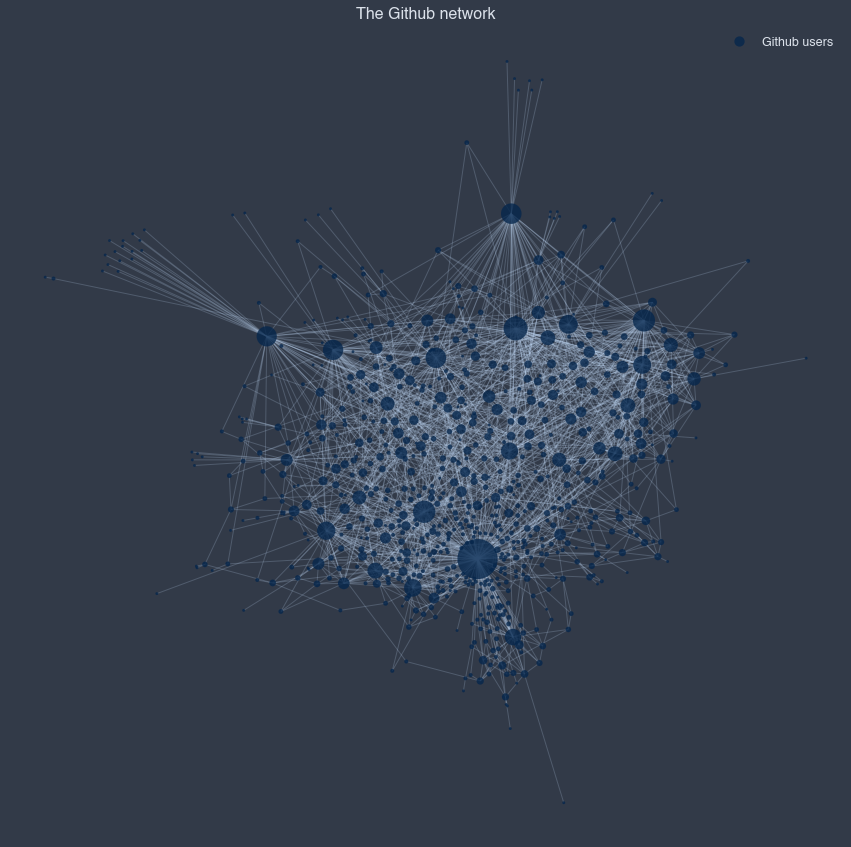

In [94]:
# Set style and figure size
jtplot.style('chesterish')
fig = plt.figure(figsize=(15,15))

# Draw network
nx.draw_networkx_nodes(giant, positions, node_color=blue[4], alpha=0.8, node_size=sizes)
nx.draw_networkx_edges(giant, positions, edge_color=blue[0], alpha=0.2)
 
# Create legend, remove axes and set title
plt.scatter([], [], c=blue[4], alpha=0.8, s=100, label='Github users')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
plt.title('The Github network', fontsize=16)
plt.axis('off')

plt.show()
fig.savefig('githubnetwork.png', facecolor=fig.get_facecolor(), transparent=True)

In [253]:
# communities
partition = community.best_partition(giant, random_state=26)
size = float(len(set(partition.values())))
print(f'Number of communities: {size}')

def get_com(comnum):
    com = [k for k,v in zip(partition.keys(),partition.values()) if v==comnum]   
    df = df_gcc[df_gcc['user_name'].isin(com)]

    
    return com, df

Number of communities: 13.0


In [272]:

def graph(comnum):
    _,df_com1= get_com(comnum)
    # store the network of users with DiGraph
    G = nx.DiGraph()
    G.add_nodes_from(df_com1['user_name'].values)

    for row in df_com1.iterrows():
        z = [(row[1]['user_name'], other_node) for other_node in row[1]['out']]
        G.add_edges_from(z)

    # extract giant connected component 
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    GCC = G.subgraph(largest_cc)
    giant2 = GCC.to_undirected()


    jtplot.style('chesterish')
    fig = plt.figure(figsize=(5,5))

    # Draw network
    nx.draw_networkx_nodes(giant2, positions, node_color=blue[4], alpha=0.8, node_size=sizes)
    nx.draw_networkx_edges(giant2, positions, edge_color=blue[0], alpha=0.2)

    # Create legend, remove axes and set title
    plt.scatter([], [], c=blue[4], alpha=0.8, s=100)
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
    plt.axis('off')
    #plt.savefig(f'{comnum}.png')


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


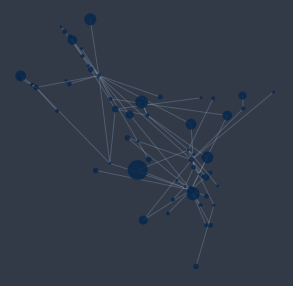

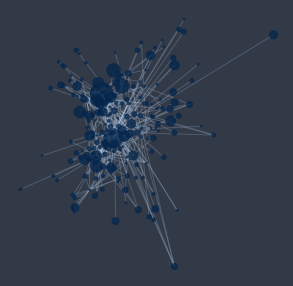

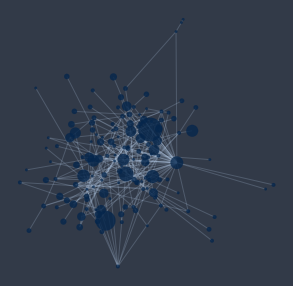

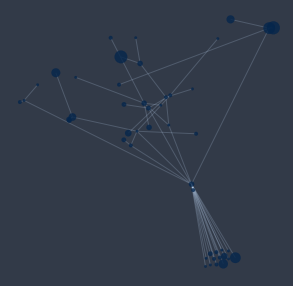

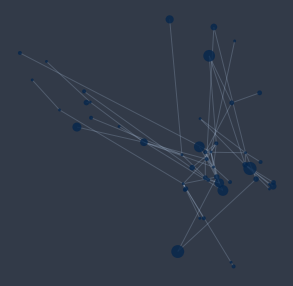

In [274]:
graph(7)
graph(2)
graph(3)
graph(5)
graph(10)

## Sentiment analysis

Number of communities: 13.0

Actual size of each community
[4, 14, 14, 33, 33, 34, 35, 41, 81, 85, 100, 114, 149]

Bins
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]


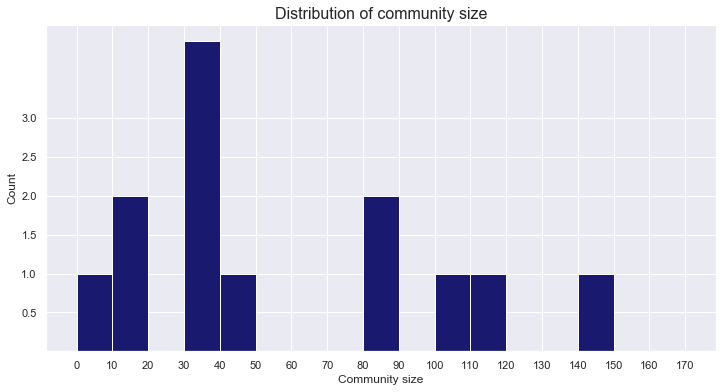

In [48]:
# get communities
partition = community.best_partition(giant, random_state=26)
size = float(len(set(partition.values())))
print(f'Number of communities: {size}')

# get communities and sizes
values = [val for val in partition.values()]
bins, counts = np.unique(values, return_counts=True)
print('\nActual size of each community')
print(sorted(counts))

# define bins 0-10,10-20, 20-30 etc
bins_def = [x*10 for x in list(range(18))]

print('\nBins')
print(bins_def)

# create histogram
plt.figure(figsize=(12, 6))
plt.hist(counts, color='midnightblue', bins=bins_def)
plt.xticks(bins_def)
plt.yticks([0.5, 1, 1.5, 2, 2.5, 3])
plt.xlabel('Community size')
plt.ylabel('Count')
plt.title('Distribution of community size', fontsize=16)
plt.show()

In [76]:
df_gcc = df[df['user_name'].isin(list(GCC.nodes))]
df_gcc.reset_index(drop=True)

,user_name,owner,repos,name,type,company,location,bio,created_at,updated_at,following,description,languages,out,in_degree,out_degree,connections,Tokens
0,josephmisiti,josephmisiti,awesome-machine-learning,Joseph Misiti,User,Math & Pencil,"Brooklyn, NY",Mathematician & Co-founder of Math & Pencil,2010-04-17T21:09:13Z,2020-10-29T18:11:39Z,"[mojombo, defunkt, vanpelt, macournoyer, ry, b...",SDK and example code for building voice-enabl...,"[C, C++, CSS, Go, Java, JavaScript, Jupyter, N...","[JWarmenhoven, agramfort, alextp, amueller, ba...",14,17,31,"[sdk, example, code, building, voiceenabled, s..."
1,wepe,wepe,MachineLearning,wepon,User,AntFin,China Hangzhou,NaN,2014-10-10T14:28:18Z,2020-11-05T15:54:10Z,"[pluskid, benanne, colah, kennethreitz42, karp...",1st Place Season one & 6th Place Season two1st...,"[C++, HTML, Java, Python, Shell]","[aymericdamien, enjoyhot, guolinke, junlulocky]",11,4,15,"[place, season, one, place, season, place, sol..."
2,ZuzooVn,ZuzooVn,machine-learning-for-software-engineers,Nam Vu,User,NaN,Vietnam,A Vietnamese Software Engineer who is really p...,2012-02-11T16:55:02Z,2020-10-12T02:40:45Z,"[ole, escoz, pokeb, tcdoan, dyang, kirill-grou...",Android executables browserEasy to use CFNetwo...,"[C, DIGITAL, Command, Language, HTML, Java, Ja...",[jwasham],6,1,7,"[android, executables, browsereasy, use, cfnet..."
3,rasbt,rasbt,python-machine-learning-book,Sebastian Raschka,User,UW-Madison,"Madison, WI",Machine Learning researcher & open source cont...,2013-10-05T16:06:10Z,2020-11-09T23:00:46Z,"[ctb, ogrisel, tacaswell, GaelVaroquaux, mblon...",My Solutions for the Advent of Code 2016A repo...,"[C, C++, CSS, HTML, Jupyter, Notebook, Lua, Op...","[amueller, jakevdp, mblondel, ogrisel, rhiever]",55,5,60,"[solution, advent, code, repository, ipython, ..."
4,Jack-Cherish,Jack-Cherish,Machine-Learning,Jack Cui,User,Northeastern University,China,:octocat:公众号：JackCui-AI,2016-01-25T03:38:06Z,2020-07-31T13:54:15Z,"[kennethreitz42, karpathy, marvis, shicai, tia...",:art:冒泡排序；直接插入排序；希尔排序；快速排序；堆排序；归并排序；基数排序C/C++:...,"[C++, HTML, Python]",[],2,0,2,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,sahil-b-shah,EpistasisLab,tpot,Sahil Shah,User,NaN,NaN,NaN,2011-05-29T17:35:13Z,2020-09-11T14:21:55Z,"[agitter, weixuanfu]",Apache Airflow - A platform to programmaticall...,"[CSS, HTML, Java, JavaScript, Matlab, Python, ...",[weixuanfu],0,1,1,
733,sohnam,EpistasisLab,tpot,NaN,User,NaN,NaN,NaN,2016-08-15T18:35:26Z,2020-09-12T07:19:17Z,[],"A tensorflow implementation of ""Deep Convoluti...","[JavaScript, Python]",[],1,0,1,
734,spiros,EpistasisLab,tpot,Spiros Denaxas,User,"University College London, Institute of Health...",London,Using AI & data to improve human health; Profe...,2008-09-09T09:01:51Z,2020-11-01T10:25:46Z,"[kaoru, argp, koikonom, freyfogle, anm, Tallma...",Athens NLP Summer School Labsatyimo: probabili...,"[C++, Dockerfile, HTML, Java, JavaScript, Jupy...",[chiphuyen],0,1,1,
735,trang1618,EpistasisLab,tpot,Trang Le,User,@EpistasisLab,"Philadelphia, PA",Postdoc fellow,2012-04-25T18:38:21Z,2020-11-10T14:32:58Z,"[makeyourownmaker, karthik, lawremi, yihui, ak...",Template resource sharing plans for grant appl...,"[C++, CSS, HTML, Jupyter, Notebook, Python, R]","[JDRomano2, PGijsbers, chiphuyen]",1,3,4,


In [177]:
def tokenize(df,col):
    df[f'Tokens_{col}'] = ""
    for i,content in enumerate(df[col]):
        try:
            text = content.translate(str.maketrans('', '', string.punctuation)).split() # split to tokens
            sw = stopwords.words("english") # set stopwords
            wordnet_lemmatizer = WordNetLemmatizer() # set lemmatizer
            words1= [t.lower() for t in text] # lower letters
            words11 = [t for t in words1 if t not in sw]   # remove stopwords
            words2 = [wordnet_lemmatizer.lemmatize(t) for t in words11]  # lemmatize
            words3 = [x for x in words2 if not any(c.isdigit() for c in x)] # remove words with numbers
            df[f'Tokens_{col}'][i] = words3
        except:
            print(i)

            


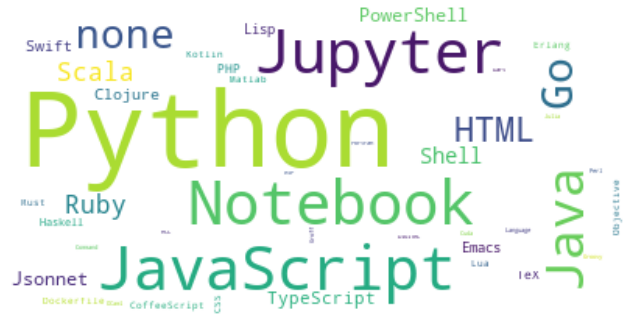

In [245]:

# create WordCloud
ll =' '.join(df['main_language'].fillna('none').tolist())
wordcloud = WordCloud(background_color = 'white', 
                      collocations = False,
                     ).generate(ll)

# plot the WordCloud image         
plt.figure(figsize=(9, 8),facecolor = None)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.savefig('languages.png')
plt.show()

<Figure size 2160x1440 with 0 Axes>

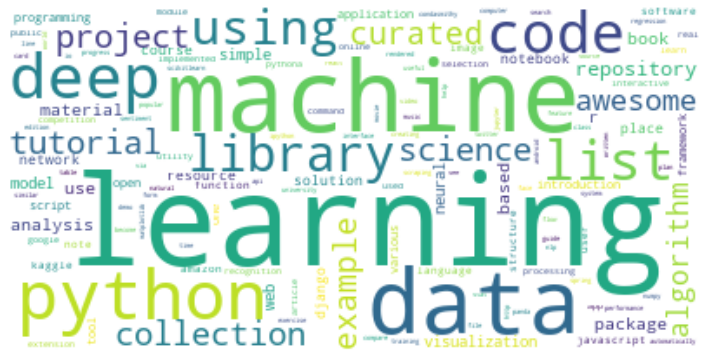

In [246]:
plt.figure(figsize=(30,20))
# create WordCloud

wordcloud = WordCloud(background_color = 'white', 
                      collocations = False,
                     ).generate_from_frequencies(TF)

# plot the WordCloud image         
plt.figure(figsize=(10, 8),facecolor = None)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.savefig('descriptions.png')
plt.show()

<Figure size 2160x1440 with 0 Axes>

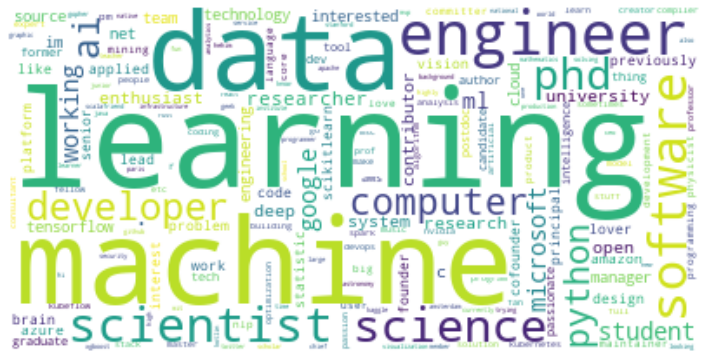

In [200]:
fig=plt.figure(figsize=(30,20))
# create WordCloud

wordcloud = WordCloud(background_color = 'white', 
                      collocations = False,
                     ).generate_from_frequencies(TF_bio)

# plot the WordCloud image         
plt.figure(figsize=(10, 8),facecolor = None)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout() 
plt.savefig('bios.png')
plt.show()